## AirBnB price prediction challenge - Berlin <br>

#### Test Question:
In preparation for the interview, we would like you to complete a short task, we expect it to take no more than 6 hours. You will present your results in a remote interview via video.

The dataset attached contains detailed listing information for AirBnB properties in Berlin on the 12th of August 2019. The task is open and an opportunity to showcase your strengths. You can use any programming language and any tool or technique you like to showcase your results, but you may well be asked to justify your methods and visualisation approach. You will be asked to spend around the first 15 minutes of your interview presenting your findings and explaining your method, after this you will be asked questions. 

* What insights can you gather? 
* How can you visualise the data? 
* What is surprising to you about the data, 
* Do you have a theory why it is that way? 
* Use Machine Learning to build a model that can predict the listing price from the other information in the data file, then evaluate your model.

You will be evaluated on: 
- The quality of your machine learning methodology and how you critically evaluate your results
- The insightfulness of any visualisations (but not how pretty they are)
- The clarity and thoughtfulness of the ideas in your presentation </br> 
 
#### Test Answers:
In Germany, Berlin is the most popular city and Airbnb has surely been the chioce for many in recent times, due to its popularity. Airbnb has significantly changed the way the traditional hospitality industry used to operate. Consequentlym Airbnb has been their primary choice for accommodation.

From our very primary findings (as demonstrated below), we have come to know that Berlin is one of the hottest markets for Airbnb in Europe, with over 24,551 listings in 2019.


The following real world business questions will drive this test tasks:

> **Can we determine a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Berlin?** <br>

> **Q1. Which neighborhoods has the most and the least expensive listings?**

> **Q2 Which neighborhoods has the most and the least expensive listings with regard to how centrally located they are?**

> **Q3. Does the distance have an impact on the price?**

> **Q4. How does the average price of the houses compare with the number of rooms?**

it is difficult to know what the true value of their home is, and how in-demand their home might be. And since location and furniture are obviously fixed for the most part, is there anything else a host can influence - such as description, communication patterns, and/or additional services to boost their earnings?

The above questions focuses on the accommodation features and decisions, which a new host can make with regards to initial presentation, i.e. posting a picture of him- or herself on the website, determining a minimum length of stay, offering instant bookings etc. A machine learning algorithm will be applied to try to get an answer. 

### The dataset
In this notebook, I will perform an analysis of the detailed Berlin listings data, sourced from the Inside Airbnb website *(as part of the test task)*, to understand the rental landscape and try to recommend a price for a the market. The dataset is named `listing_90PoE.csv`.


## Table of Contents
<a id='Top'> Top </a>

### <a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

### <a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* a) Deciding which columns to work with
* b) Cleaning Price Columns
* c) Dealing with Missing Values
* d) Feature Engineering 1: Distance to Centroid of Berlin 
* e) Feature Engineering 2: Lodging Size 
* f) Feature Engineering 3: Lodging Amenities

### <a href='#3. Exploratory Data Analysis (EDA)'> 3. Exploratory Data Analysis (EDA) </a>

### <a href='#4. Modeling the Data'> 4. Modeling the Data </a>
* a) Preparing Target and Features
* b) Splitting and Scaling the Data
* c) Training an XGBoost Regressor
* d) Cross Validation

### <a href='#5. Interpreting the Data'> 5. Interpreting the Data </a>

### <a href='#6. Appendix'> 6. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_primary = pd.read_csv('/Users/drarindamghosh/Documents/AirBnB/listings.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_primary.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_primary.duplicated().sum()))

The dataset has 24551 rows and 106 columns.
It contains 0 duplicates.


In [3]:
df_primary.head(1)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1944,https://www.airbnb.com/rooms/1944,20190812143128,43690,cafeheaven Pberg/Mitte/Wed for the summer 2019,"Private, bright and friendly room. You'd be sh...","The room is very large, private, cozy, bright,...","Private, bright and friendly room. You'd be sh...",none,near all the trendy cafés and flea markets and...,...,f,f,moderate,f,f,1,0,1,0,0.25


In [4]:
# check the columns we currently have
df_primary.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

*Back to: <a href='#Top'> Top</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### a) Deciding which columns to work with 

Let's take some real life use case: 
Let's think someone who'd like to offer their home. 
> 1. Fixed features of our property include: 
        a) Rooms
        b) Size 
        c) Location 
> 2. We also can decide on how we want to be listed:  <br>
        a) with a picture or not, how many minimum nights we want a guest to stay,<br>
        b) whether we are instantly bookable
        c) how we handle cancellations

So, let's focus only on features we can influence:

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df_raw = df_primary[columns_to_keep].set_index('id')
print("After dropping irrelevant columns, the dataset has {} rows and {} columns.".format(*df_raw.shape))

After dropping irrelevant columns, the dataset has 24551 rows and 23 columns.


By the way, how many different **room types** do we have?

In [6]:
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.499898
Private room       0.486864
Shared room        0.013238
Name: room_type, dtype: float64

And how many different **property types** are we up against?

In [7]:
df_raw.property_type.value_counts(normalize=True)

Apartment                 0.886074
Condominium               0.025783
Loft                      0.019510
House                     0.018655
Serviced apartment        0.013319
Hostel                    0.008472
Townhouse                 0.004643
Boutique hotel            0.003666
Hotel                     0.003421
Bed and breakfast         0.003218
Guest suite               0.002933
Guesthouse                0.002566
Other                     0.001507
Bungalow                  0.000937
Houseboat                 0.000774
Boat                      0.000733
Villa                     0.000611
Aparthotel                0.000530
Tiny house                0.000489
Cabin                     0.000326
Cottage                   0.000326
Pension (South Korea)     0.000326
Camper/RV                 0.000244
Barn                      0.000163
Resort                    0.000122
Treehouse                 0.000122
Castle                    0.000122
Casa particular (Cuba)    0.000081
Train               

*Back to: <a href='#Top'> Top</a>*
#### b) Cleaning Price Columns

In [8]:
df_raw[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
1944,$21.00,$0.00,$10.00,$0.00
2015,$60.00,$30.00,$28.00,$250.00
3176,$90.00,$100.00,$20.00,$300.00


Let's first check, if there are any null values in the `price` column: (*It is always recommended to check for null values in any dataset*)

In [9]:
# checking Nan's in "price" column
df_raw.price.isna().sum()

0

No, so we don't need to drop any rows. Now, how about the `cleaning_fee`?

In [10]:
# Nan's in "cleaning_fee" column
df_raw.cleaning_fee.isna().sum()

7280

There are plenty of Nan's in the `cleaning_fee` column. 
It's more than likely that these hosts do not charge any extra cleaning fee. So let's simply replace these null values with $0.00:

In [11]:
df_raw.cleaning_fee.fillna('$0.00', inplace=True)
df_raw.cleaning_fee.isna().sum()

0

We will perform the same action with the `security_deposit`:  . And the same is true for this column, plenty of Nan's values.

In [12]:
df_raw.security_deposit.isna().sum()

9624

Again, simply replace these null values with $0.00:

In [13]:
df_raw.security_deposit.fillna('$0.00', inplace=True)
df_raw.security_deposit.isna().sum()

0

In [14]:
df_raw.extra_people.isna().sum()

0

Let's us now check, which columns have the dollar signs. <br>
Therefore, let's remove the dollar signs in allcolumns and convert the string values into numerical ones: (*this is again a very basic check for keeping a uniformity amongst the data*)

In [15]:
# clean up the columns (by method chaining)
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.cleaning_fee = df_raw.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.security_deposit = df_raw.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df_raw.extra_people = df_raw.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

We shouldn't miss investigating the `price` - it might need some cleaning to be of use to us:

In [16]:
df_raw['price'].describe()

count    24551.000000
mean        72.928272
std        236.193057
min          0.000000
25%         33.000000
50%         50.000000
75%         75.000000
max       9000.000000
Name: price, dtype: float64

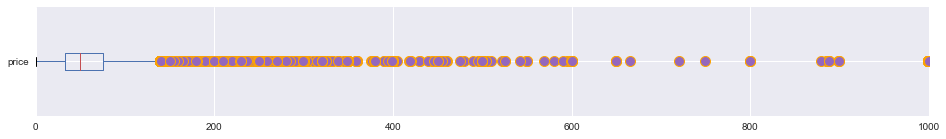

In [17]:
filled_marker_style = dict(marker='o', markersize=10,
                           color='darkgrey',
                           markerfacecolor='tab:purple',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='orange')
df_raw['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=filled_marker_style, figsize=(16,2));

As you can see from the above boxplot that about 80% of the apartments charge between 68 to 75 Euros (in German currency eruos). 

Therefore, we need to decide on a limit, as the outliers seem to disperse after 400€, and drop all records that charge more than that. <br>
Although, there are some places where we have prices set to zero. So we need to drop those records. 

In [18]:
df_raw.drop(df_raw[ (df_raw.price > 400) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [19]:
df_raw['price'].describe()

count    24371.000000
mean        61.195273
std         44.777844
min          1.000000
25%         32.000000
50%         50.000000
75%         75.000000
max        400.000000
Name: price, dtype: float64

In [20]:
print("Price-wise preprocessed dataset that has {} rows and {} columns.".format(*df_raw.shape))

Price-wise preprocessed dataset that has 24371 rows and 23 columns.


*Back to: <a href='#Top'> Top</a>*
#### c) Dealing with Missing Values

In [21]:
df_raw.isna().sum()

space                            8639
description                       365
host_has_profile_pic               50
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                          29
bedrooms                           19
bed_type                            0
amenities                           0
square_feet                     23941
price                               0
cleaning_fee                        0
security_deposit                    0
extra_people                        0
guests_included                     0
minimum_nights                      0
instant_bookable                    0
is_business_travel_ready            0
cancellation_policy                 1
dtype: int64

In [22]:
# drop columns with too many Nan's - (It is always recommended to check for null values in any dataset)
df_raw.drop(columns=['square_feet', 'space'], inplace=True)

In [23]:
# drop rows with NaN's in bathrooms, bedrooms and cancellation_policy - (It is always recommended to check for null values in any dataset)
df_raw.dropna(subset=['bathrooms', 'bedrooms', 'cancellation_policy'], inplace=True)

In [24]:
df_raw.host_has_profile_pic.unique()

array(['t', nan, 'f'], dtype=object)

In [25]:
# replace host_has_profile_pic Nan's with no pics meaning 'False' i.e. 'f'
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [26]:
df_raw.isna().sum()

description                     365
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
bedrooms                          0
bed_type                          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
is_business_travel_ready          0
cancellation_policy               0
dtype: int64

In [27]:
print("After having dealt with missing values, the dataset has {} rows and {} columns - after having dealt with missing values.".format(*df_raw.shape))

After having dealt with missing values, the dataset has 24322 rows and 21 columns - after having dealt with missing values.


*Back to: <a href='#Top'> Top</a>*
#### d) Feature Engineering 1: Distance to Centroid of Berlin

Location has always been the central focus of how an Airbnb locations gain listings which helps in predicting the price. It is imperative to calculate the distance of various Airbnb locations from the centre of Berlin. Therefore, I decided to calculate each accommodation's distance to centroid of Berlin instead of just relying on the neighbourhoods or areas. 

For our convenience, let's write a quick function that does this, apply it to each accommodation, and store the values in a new column:

In [28]:
from geopy.distance import great_circle

In [29]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [30]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [31]:
df_raw.head(2)

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance
id,,,,,,,,,,,,,,,,,,,,,
1944,"Private, bright and friendly room. You'd be sh...",t,Mitte,52.54425,13.39749,Apartment,Private room,1,1.0,1.0,...,21.0,0.0,0.0,10.0,1,120,f,f,moderate,4.633575
2015,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.53454,13.40256,Guesthouse,Entire home/apt,3,1.0,1.0,...,60.0,30.0,250.0,28.0,1,4,f,f,moderate,3.533473


*Back to: <a href='#Top'> Top</a>*
#### e) Feature Engineering 2: Lodging Size

One of the most important pieces of information for predicting the price is the size. <br>
Since the column `square_feet` was heavily filled with null values, we dropped it in the previous section. <br>
(Besides, size in Germany is expressed in square meters, not in square feet.)

Let's check, if the column `description` reveals any information about size instead: 

In [32]:
list(df_raw.description[:5])  

["Private, bright and friendly room. You'd be sharing the flat with An, a Vietnamese IT guy, 25, fluent in German, and Ignacio, 24, a Spanish Communications Design student, and sometimes our little dog Mila :-) The room is very large, private, cozy, bright, and quiet because it faces the tree-filled courtyard. You can see beautiful sunsets from the window and you also have a balcony. It's 28 m2 in a 100 m2 apartment near Mitte, Prenzlauer Berg, Wedding, Mauerpark, Kastanienallee and Oderbergerstrasse with the flea markets, clubs, cafes and bars. It's also very central, near the Ubahn 8 and 2 and various Sbahns, about 10 minutes from Alexanderplatz and 20 from Kreuzberg and Neuköln.  We have a great dog named Mila, so you'd have to like animals and not have allergies! Your room, the bathroom and the kitchen, and of course the hallway connecting everything. There is also a great balcony, you have use of that as well. I'll be traveling a lot in the summer and not there a lot, but you can 

>As you can see above, just to acknowledege the rich content which the description column details is good enough to extract some key information. 

In [33]:
df_raw.description.isna().sum()

365

The `description` column seems to be rich in content. Let's extract 
- all double digit or three digit numbers, that are followed by one of the two characters "s" or "m" (covering "sqm", "square meters", "m2" etc.) and 
- may or may not be connected by white space. 

Single  or more than three digit numbers for accommodation sizes are quite unlikely.



***Extracting size from text***

In [34]:
# extract numbers 
df_raw['size'] = df_raw['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)
df_raw['size'] = df_raw['size'].str.replace("\D", "")

# change datatype of size into float - (*again very important to do these checks time to time*)
df_raw['size'] = df_raw['size'].astype(float)

# Agin, time to time, it is always recommended to check for null values in any dataset
print('NaNs in size_column absolute:     ', df_raw['size'].isna().sum()) 
print('NaNs in size_column in percentage:', round(df_raw['size'].isna().sum()/len(df_raw),3), '%')

NaNs in size_column absolute:      12596
NaNs in size_column in percentage: 0.518 %


In [35]:
df_raw[['description', 'size']].head(10)

,description,size
id,,
1944,"Private, bright and friendly room. You'd be sh...",28.0
2015,Great location! 30 of 75 sq meters. This wood...,75.0
3176,This beautiful first floor apartment is situa...,68.0
3309,First of all: I prefer short-notice bookings. ...,26.0
6883,Stay in a stylish loft on the second floor and...,63.0
7071,Cozy and large room in the beautiful district ...,20.0
9991,4 bedroom with very large windows and outstand...,780.0
14325,The apartment is located on the upper second f...,NaN
16401,Hello future guests! We want to rent our cute ...,55.0


In [36]:
#list(df_raw.description[:10])

Comparing the results, we did a pretty good job with the first 4 records, but filtered an incorrect number for the last record. Okay, let's keep that in mind: there may be mistakes in the size we engineered from the text! 

In [37]:
# drop description column
df_raw.drop(['description'], axis=1, inplace=True)

***Predicting missing values with regression***

>Key Observations from the dataset at this point: <br>

As of from all the observations from the above exercise we relaise that, half of our records still don't have a size. 
This means we have a problem! Moreover, dropping these records isn't a good option as we will loose significant amount of valuable information. 
Furthermore, simply replacing them with the '*mean*' or '*median*' makes no sense. 

Therefore, the only option we are left is to: <br>
Predict the missing value with a Machine Learning Algorithm. <br>
Not to make it too complicated, we'll only use numerical features. Next, we have to split our data into two sets:
- a) a training set where we have sizes and 
- b) a test set where we don't.

In [38]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24322 entries, 1944 to 37698736
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   host_has_profile_pic          24322 non-null  object 
 1   neighbourhood_group_cleansed  24322 non-null  object 
 2   latitude                      24322 non-null  float64
 3   longitude                     24322 non-null  float64
 4   property_type                 24322 non-null  object 
 5   room_type                     24322 non-null  object 
 6   accommodates                  24322 non-null  int64  
 7   bathrooms                     24322 non-null  float64
 8   bedrooms                      24322 non-null  float64
 9   bed_type                      24322 non-null  object 
 10  amenities                     24322 non-null  object 
 11  price                         24322 non-null  float64
 12  cleaning_fee                  24322 non-null  float64


In [39]:
# filter out sub_df to work with
sub_df = df_raw[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
                 'security_deposit', 'extra_people', 'guests_included', 'distance', 'size']]

In [40]:
# split datasets
train_data = sub_df[sub_df['size'].notnull()]
test_data  = sub_df[sub_df['size'].isnull()]

# define X
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y
y_train = train_data['size']

In [41]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (11726, 10)
Shape of Test Data:     (12596, 10)

Shape of X_train: (11726, 9)
Shape of X_test: (12596, 9)

Shape of y_train: (11726,)


In [42]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate Linear Regression
linreg = LinearRegression()

# fit model to training data
linreg.fit(X_train, y_train)

LinearRegression()

In [43]:
# making predictions
y_test = linreg.predict(X_test)

With the above step, now we have predicted the missing sizes, let's cast `y_test` into a dataframe with a column `size`:

In [44]:
y_test = pd.DataFrame(y_test)
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(12596, 1)


,size
0,59.375335
1,94.135352
2,74.036426
3,86.582976
4,65.538141


In [45]:
print(X_test.shape)
X_test.head()

(12596, 9)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance
id,,,,,,,,,
14325,1,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012693
20858,4,1.0,2.0,129.0,49.0,500.0,29.0,2,3.806958
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061303
22415,4,1.0,2.0,98.0,60.0,300.0,25.0,2,1.868251
28156,1,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886582


To combine `y_test` and `X_test` back to our full test_dataframe, we have to match and sync the indexing first. <br>
Therefore, as you can see from the above, the `X_test` dataframe has a specific index that's not compatible with `y_test`, where the numbers simply start from 0 onwards. So we need to provide `y_test` with the `X_test` index to make sure everyting fits together.

In [46]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)
y_test.head()

,size
prelim,
14325,59.375335
20858,94.135352
21869,74.036426
22415,86.582976
28156,65.538141


In [47]:
new_test_data = pd.concat([X_test, y_test], axis=1)

In [48]:
print(new_test_data.shape)
new_test_data.head()

(12596, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,1,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012693,59.375335
20858,4,1.0,2.0,129.0,49.0,500.0,29.0,2,3.806958,94.135352
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061303,74.036426
22415,4,1.0,2.0,98.0,60.0,300.0,25.0,2,1.868251,86.582976
28156,1,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886582,65.538141


In [49]:
new_test_data['size'].isna().sum() #This line finally confirm against our dataset that we don't have any Nan's

0

Once we have completed our new train_data, we stack test_data and train_data back to a new sub_dataframe across the rows:

In [50]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([new_test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head()

(24322, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size
14325,1,1.0,0.0,70.0,0.0,500.0,0.0,1,5.012693,59.375335
20858,4,1.0,2.0,129.0,49.0,500.0,29.0,2,3.806958,94.135352
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,2.061303,74.036426
22415,4,1.0,2.0,98.0,60.0,300.0,25.0,2,1.868251,86.582976
28156,1,1.0,0.0,70.0,0.0,1660.0,0.0,1,4.886582,65.538141


In [51]:
sub_df_new['size'].isna().sum()

0

Finally, the last big step: is to merge our new sub_dataframe with the remaining columns from our original dataframe - this time, across the columns:

In [52]:
# prepare the multiple columns before concatening
df_raw.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

In [53]:
# concate back to complete dataframe
df = pd.concat([sub_df_new, df_raw], axis=1)

print(df.shape)
df.head(2)

(24322, 22)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
1944,1,1.0,1.0,21.0,0.0,0.0,10.0,1,4.633575,28.0,...,52.54425,13.39749,Apartment,Private room,Real Bed,"{""Cable TV"",Internet,Wifi,""Free street parking...",120,f,f,moderate
2015,3,1.0,1.0,60.0,30.0,250.0,28.0,1,3.533473,75.0,...,52.53454,13.40256,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,moderate


***Investigating sizes***

Let's thoroughly examine our new `size` column:

In [54]:
df['size'].isna().sum()

0

In [55]:
df['size'].describe()

count    24322.000000
mean        61.427532
std         82.201385
min          0.000000
25%         24.000000
50%         50.039764
75%         66.583089
max        980.000000
Name: size, dtype: float64

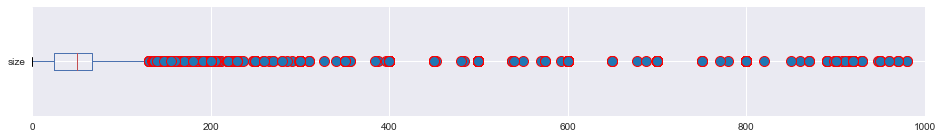

In [56]:
filled_marker_style = dict(marker='o', markersize=10,
                           color='darkgrey',
                           markerfacecolor='tab:blue',
                           markerfacecoloralt='lightsteelblue',
                           markeredgecolor='red')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=filled_marker_style, figsize=(16,2));

To be on the safer side, let’s remove all outliers starting or over 300 square meters, and all those with 0:

In [57]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

In [58]:
print("After being engineered, the dataset has {} rows and {} columns.".format(*df.shape))

After being engineered, the dataset has 23834 rows and 22 columns.


*Back to: <a href='#Top'> Top</a>*
#### f) Feature Engineering 3: Lodging Amenities

Finally, from the observation noted above along with location and size of the accomodation even the '*amenities*' play an important role in determining and predicting the price.
Therefore, I am very intrigued by the amenities that the hosts have to offer to their guests. <br>
In addition, in order to enrich our prediction, whether we can determine which special/rare/extra amenities which make a property more in demand.

In [59]:
from collections import Counter

In [60]:
results = Counter()
df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 22791),
 ('Heating', 22474),
 ('Kitchen', 22438),
 ('Essentials', 21703),
 ('Washer', 19464),
 ('Hair dryer', 16205),
 ('Laptop friendly workspace', 15738),
 ('Hangers', 15245),
 ('Iron', 12283),
 ('Shampoo', 11549),
 ('Hot water', 10809),
 ('TV', 10660),
 ('Smoke detector', 8246),
 ('Family/kid friendly', 7132),
 ('Internet', 7041),
 ('Refrigerator', 6961),
 ('Dishes and silverware', 6736),
 ('Cooking basics', 6458),
 ('Stove', 6440),
 ('Bed linens', 6370),
 ('Host greets you', 6282),
 ('Lock on bedroom door', 6136),
 ('Oven', 5785),
 ('Buzzer/wireless intercom', 5444),
 ('Elevator', 5346),
 ('Free street parking', 5312),
 ('Coffee maker', 4936),
 ('Smoking allowed', 4577),
 ('First aid kit', 4418),
 ('Dishwasher', 4325)]

In [61]:
# create a new dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

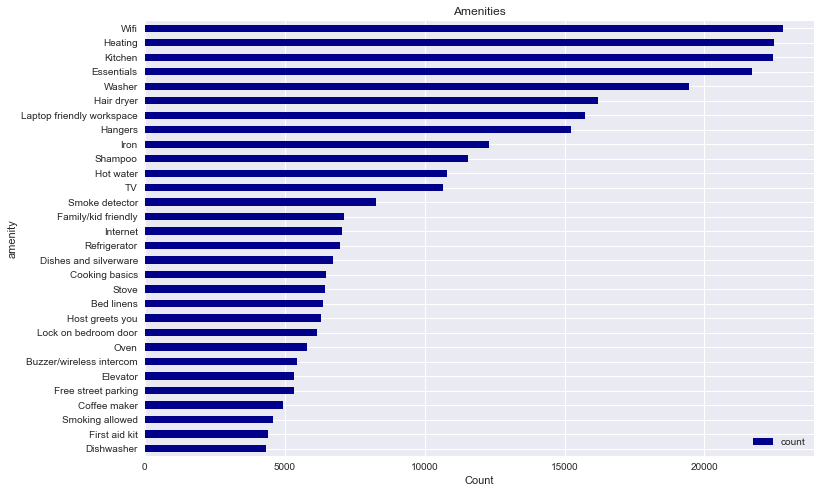

In [62]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',
                                                      figsize=(12,8), legend=True, color='darkblue',
                                                      title='Amenities')
plt.xlabel('Count');

As you can see from the above figure that the most common amenity offerd by all host is: 
- Wi-Fi <br>
However, the interesting thing would be to see the unique ones.
    
Let's now add columns with amenities that are somewhat unique and not offered by all hosts: 

- a laptop-friendly workspace
- a TV
- kid friendly accommodation 
- smoker friendly and 
- being greeted by the host.

Now that we have selected the unique amenities,let's drop the original column:

In [63]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [64]:
df.drop(['amenities'], axis=1, inplace=True)

*Back to: <a href='#Top'> Top</a>*
### 3. Exploratory Data Analysis (EDA)
<a id='3. Exploratory Data Analysis (EDA)' ></a>

**> The figure below shows the "Price Difference on a Map"**

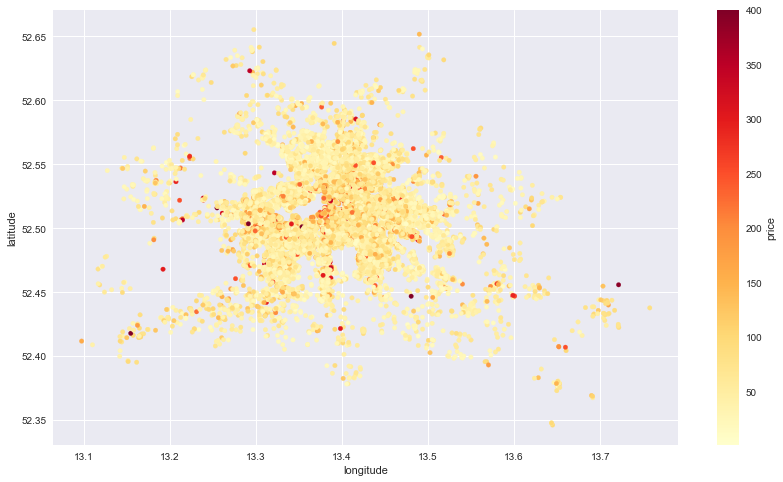

In [65]:
#df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(14,8), 
#        c='price', cmap="gist_heat_r", colorbar=True, sharex=False);  
####
#df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(14,8), 
#        c='price', cmap="Reds", colorbar=True, sharex=False); # Best options: YlOrBr, YlGn, OrRd
####
df.plot(kind="scatter", x="longitude", y="latitude", figsize=(14,8), 
        c='price', cmap="YlOrRd", colorbar=True, sharex=False);

With the above EDA analysis shown with the scatter plot, it is qiute evident that the higly priced Airbnb locations are somewhat centrally located!

**> The figure below shows the "Price Difference by Neighbourhood"** 

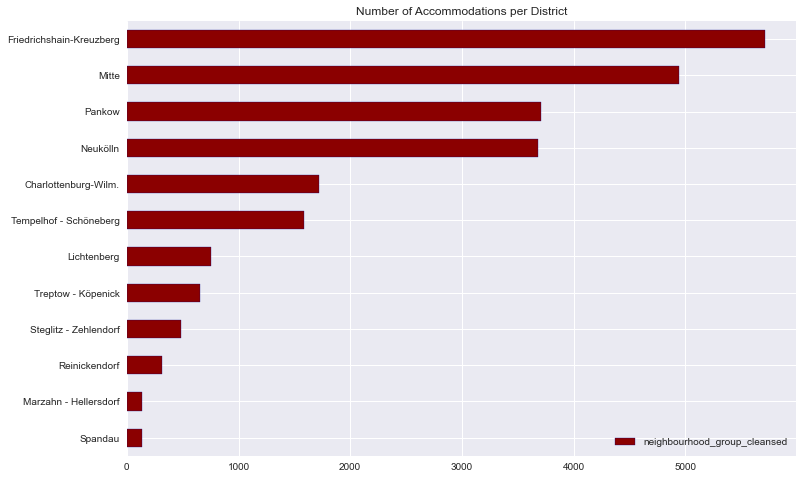

In [66]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', facecolor='darkred', edgecolor='darkblue', 
                                                                     figsize=(12,8), legend=True)
plt.title('Number of Accommodations per District');

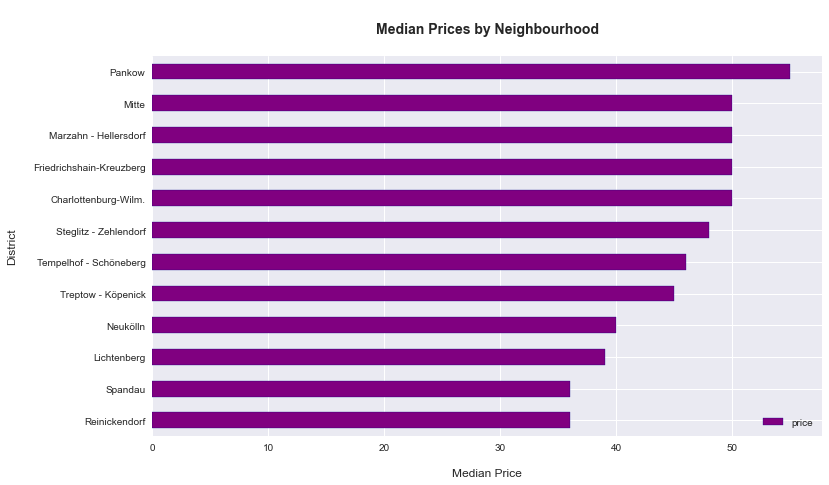

In [67]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(12,7), legend=True, color='salmon', facecolor='purple', edgecolor='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold');

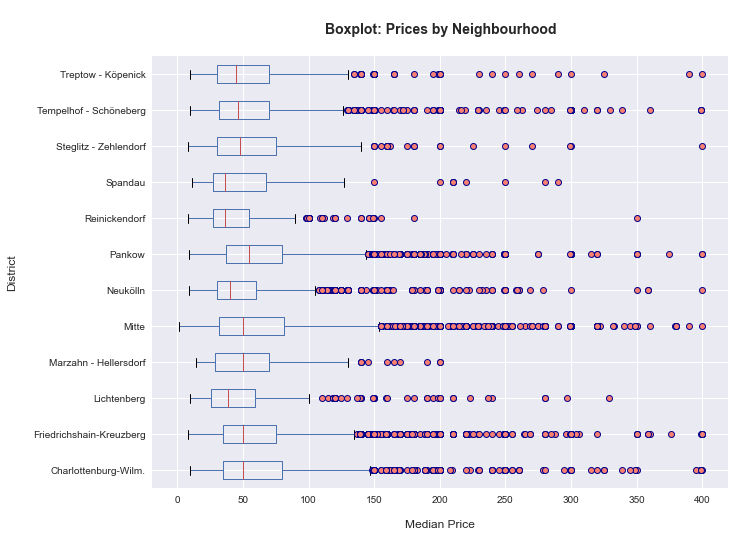

In [68]:
salmon_square = dict(markerfacecolor='salmon', markeredgecolor='darkblue', marker='o')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=salmon_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

# get rid of automatic boxplot title
plt.suptitle('');

**> The figure below shows the "Price Difference by Distance of Accommodation from the Center of Berlin"**

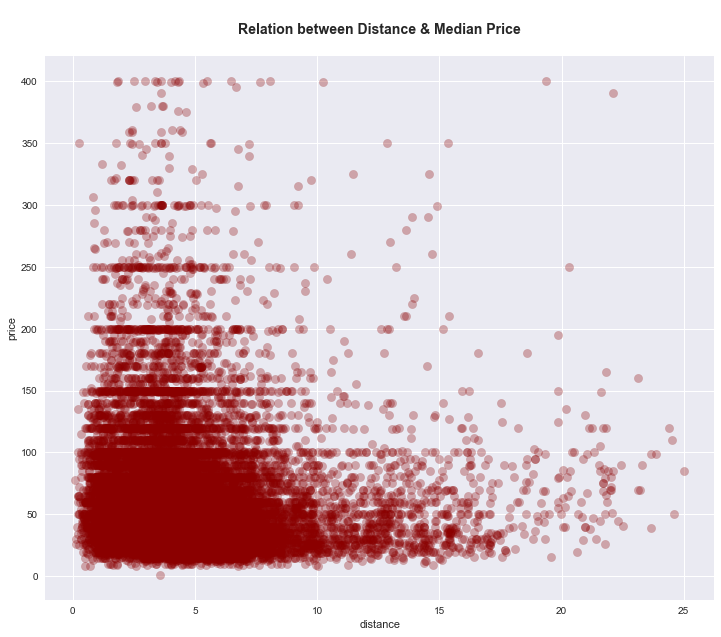

In [69]:
df.plot.scatter(x="distance", y="price", figsize=(12,10), color='darkred', s=70, marker='o', alpha=0.3)
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold');

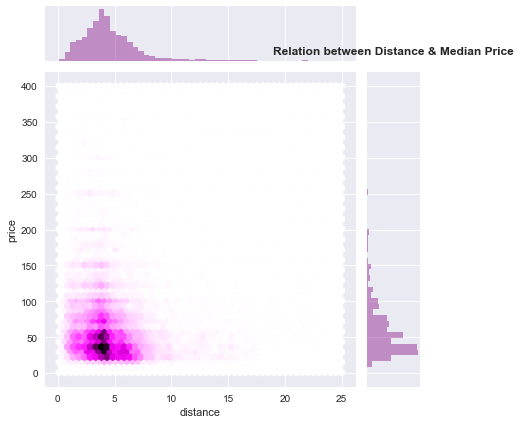

In [70]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex', color='purple')
plt.title('\nRelation between Distance & Median Price\n', fontsize=12, fontweight='bold');

**> The figure below shows the "Price Difference by Accommodation Size"**

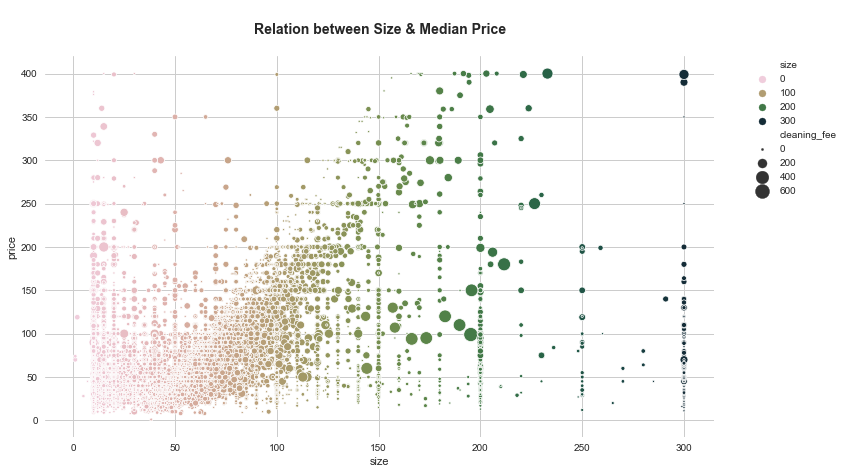

In [71]:
sns.set_style("whitegrid")
#cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
cmap = sns.cubehelix_palette(rot=-.9, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df, marker='o')

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

**> The figure below shows the "Price Difference by Number of Bedrooms"**

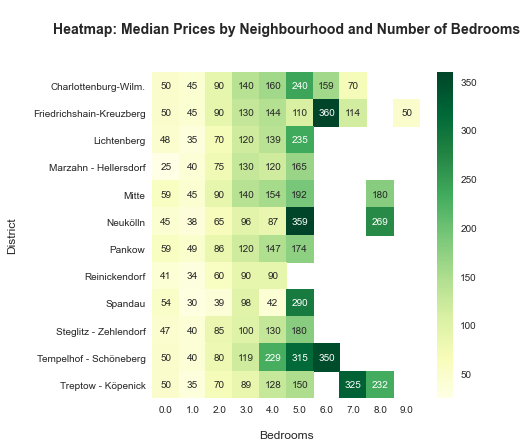

In [72]:
plt.figure(figsize=(6,6))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='YlGn', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold');

**> The figure below shows the "Price Differences by Cancellation Policy"**

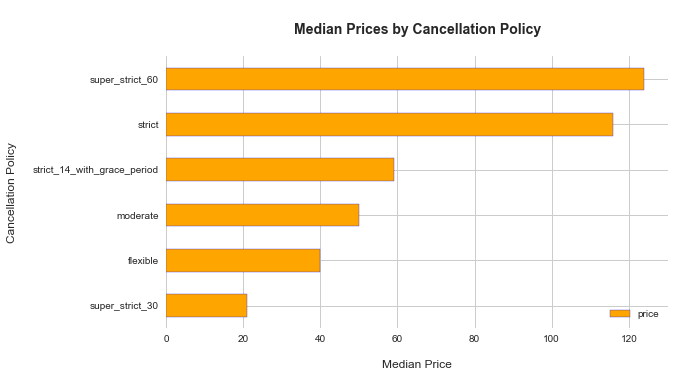

In [73]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_grouped = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_grouped.reset_index(inplace=True)

# plot this 
df_grouped.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=True, facecolor='orange', edgecolor='blue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold');

*Back to: <a href='#Top'> Top</a>*
### 4. Modeling the Data 
<a id='4. Modeling the Data'></a>

#### a) Preparing Target and Features

In [74]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'distance',
       'size', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
       'latitude', 'longitude', 'property_type', 'room_type', 'bed_type',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready',
       'cancellation_policy', 'Laptop_friendly_workspace', 'TV',
       'Family_kid_friendly', 'Host_greets_you', 'Smoking_allowed'],
      dtype='object')

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23834 entries, 1944 to 37698736
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  23834 non-null  int64  
 1   bathrooms                     23834 non-null  float64
 2   bedrooms                      23834 non-null  float64
 3   price                         23834 non-null  float64
 4   cleaning_fee                  23834 non-null  float64
 5   security_deposit              23834 non-null  float64
 6   extra_people                  23834 non-null  float64
 7   guests_included               23834 non-null  int64  
 8   distance                      23834 non-null  float64
 9   size                          23834 non-null  float64
 10  host_has_profile_pic          23834 non-null  object 
 11  neighbourhood_group_cleansed  23834 non-null  object 
 12  latitude                      23834 non-null  float64


Now that we will start to model the dataset properly, let us drop all the unwanted colums. Hence, let's drop the `neighbourhood_group_cleansed`, as we will work with the distance. In addition, we will drop `latitude`, `longitude` as well. <br>
Furthermore, we will also drop the `property_types`, as it might not be that useful.

In [76]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

Now let's convert all string columns into categorical ones:

In [77]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [78]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

***Recoding Categorical Features***

### Key Important Step before Machine Learning is applied:

It is considered to be the most imortant rule for Machine learning algorithms is to utilise as much as data, therefore, it should utilise all the data, including categorical data (in numeric form). <br>

In order to satisfy these algorithms, dummy variables are created with separate binary features by converting categorical features. 
Therefore, we have to find a way to represent these variables as numbers before handing them off to the ML model. 

One typical way of doing this in one-hot encoding, which creates a new column for each unique category in a categorical variable. Each observation receives a 1 in the column for its corresponding category and a 0 in all other new columns. To conduct one-hot encoding, we use the pandas get_dummies function.

In [79]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [80]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [81]:
print(features_recoded.shape)
features_recoded.head(2)

(23834, 34)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,distance,size,minimum_nights,...,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
1944,1,1.0,1.0,0.0,0.0,10.0,1,4.633575,28.0,120,...,1,1,0,1,0,1,0,0,0,0
2015,3,1.0,1.0,30.0,250.0,28.0,1,3.533473,75.0,4,...,1,1,0,1,0,1,0,0,0,0


*Back to: <a href='#Top'> Top</a>*
#### b) Splitting and Scaling the Data

In [82]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

### Challenges in building Models:

One of the challenges in building models is mixing features that have different scales. <br> 

For example, in our dataset, if we compare bathrooms, size and maximum_nights. When we mix units with ranges that have different orders of magnitude, therefore our models may not be able to find the proper coefficients. <br>

To cater to this problem, we standardize or normalize the features.

In [83]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

c) Training an XGBoost Regressor*Back to: <a href='#Top'> Top</a>*
#### c) Training an XGBoost Regressor

In [84]:
# create a baseline
booster = xgb.XGBRegressor()

Some of the important hyperparameters to tune an XGBoost are:

- `n_estimators` $\;\;\;\;\;\;$ = Number of trees one wants to build.

- `learning_rate` $\;\;\;\;$ = Rate at which our model learns patterns in data. After every round, it shrinks the feature weights to reach the best optimum.

- `max_depth` $\;\;\;\;\;\;\;\;\;\;\;$ = Determines how deeply each tree is allowed to grow during any boosting round.

- `colsample_bytree`  = Percentage of features used per tree. 

- `gamma` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  = Specifies the minimum loss reduction required to make a split.

In [85]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [86]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

In [87]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 24.4531


In [88]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.6837


*Back to: <a href='#Top'> Top</a>*
#### d) Cross Validation

In order to build a very robust model(s), it is common practice or let's say best practice to conduct a <b>*k-fold*</b> cross validation where all the entries in the original training dataset are used for both training and validation. XGBoost supports k-fold cross validation via the cv method. All we have to do is specify the `nfolds` parameter, which is the number of cross validation rounds you want to build. 

Also, it supports many other parameters:
- `num_boost_round` $\;\;\;\;\;\;\;\;$ = Specifies the number of trees to build (analogous to n_estimators).
- `metrics` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ = Specifies the evaluation metrics to be checked during CV.
- `as_pandas` $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$= Returns the results in a decent pandas DataFrame.
- `early_stopping_rounds` = Finishes model training early if the hold-out metric does not improve for a given number of rounds. 

We will have to first convert the dataset into an optimized data structure called DMatrix so that XGBoost's cross validation method is supported.

In [89]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [90]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [91]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,72.322940,0.223416,72.365265,0.447227
1,69.404457,0.166606,69.500071,0.474440
2,66.571281,0.190234,66.725688,0.486920
3,63.907160,0.213917,64.114964,0.507953
4,61.452412,0.128482,61.688815,0.522786


In [92]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
195,18.305904,0.417574,24.548111,0.389238
196,18.284395,0.426232,24.541546,0.383843
197,18.272539,0.431429,24.540604,0.383525
198,18.250336,0.441006,24.535968,0.377719
199,18.228360,0.434828,24.533111,0.378899


In [93]:
cv_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   train-rmse-mean  200 non-null    float64
 1   train-rmse-std   200 non-null    float64
 2   test-rmse-mean   200 non-null    float64
 3   test-rmse-std    200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


*Back to: <a href='#Top'> Top</a>*
### 5. Interpreting the Data 
<a id='5. Interpreting the Data'></a>

From the above results, We can see that our average error (Root Mean Square Error - RMSE) in the initial XGBoost is around €23, which improves to about €18 by cross validation. <br> 

Given the fact that after cleaning up the price column, 50% of our lodgings cost only up to 50€ and 75% of our lodgings up to 80€, even the improved standard deviation of 18€ is quite a massive inaccuracy that doesn't help much in recommending a price.

It turns out that the price is dependent not only on the <u>geography</u>, <u>size</u>, and <u>features</u> but also on the basis of reasoning of various factor as highlighted below: 

- the quality of presentation (e.g. pictures), 
- availability, 
- the number and content of reviews, 
- communication (e.g. acceptance rate, host response time) or 
- status ((whether or not the host is a super host)) 

These above features might also play a significant part too.  

But the purpose of this analysis was to recommend a price without any reviews or status.<br>

Keeping this in mind, we recommend that we can't recommend an exact price, however we could rather specify a <b><u>`price range`</u></b> from the above evaluation.

The next step (and maybe an idea for the reader) would be to start all over again and include the features mentioned above to try to find out if accuracy improves. That might help a beginner on Airbnb better know what price to aim for.

With what we have done here, we have explained 75% of the variance (R^2) with the most important accommodation features, as pictured below:

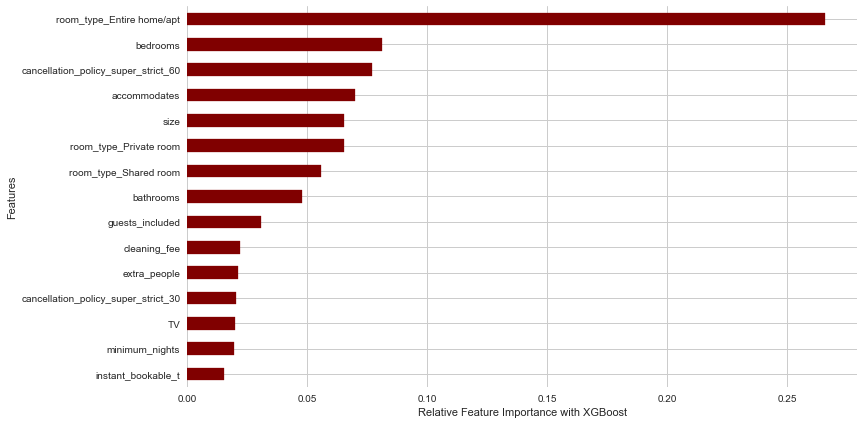

In [94]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', facecolor='maroon', edgecolor='darkred', figsize=(12,7))
plt.xlabel('Relative Feature Importance with XGBoost');
plt.ylabel('Features');

As we see, the **most important features are <u>room_type_Entire home/apt</u>, <u>bedrooms</u>, <u>size</u>, and <u>accomodates</u>**, which account for approximately 50% of the daily price. Other top features are the bathrooms, room_type_Shared room or the room_type_Private room and cancellation_policy_super_strict_60

*Back to: <a href='#Top'> Top</a>*
### 6. Appendix 
<a id='6. Appendix'></a>

All resources used in this notebook are listed below.

Data
- Available on request via email.  

Inspiration for Analysis
- https://towardsdatascience.com/digging-into-airbnb-data-reviews-sentiments-superhosts-and-prices-prediction-part1-6c80ccb26c6a
- https://www.kaggle.com/ibjohnsson/predicting-listing-prices
- https://www.kaggle.com/mathvv/prediction-on-house-prices-xgboost-tutorial
- https://towardsdatascience.com/improving-airbnb-yield-prediction-with-text-mining-9472c0181731
- https://github.com/joaeechew/airbnb_nlp/blob/master/Capstone%20Project.ipynb

Inputing missing values with Linear Regression
- https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d

XGBoost
- https://www.datacamp.com/community/tutorials/xgboost-in-python
- https://www.kaggle.com/marcelo06/cross-validation-with-xgboost-python

Geocoding
- https://pypi.org/project/geopy/

Visualizations
- https://python-graph-gallery.com
- https://www.kaggle.com/kostyabahshetsyan/boston-airbnb-visualization
